<a href="https://colab.research.google.com/github/RakshithaBS/Automatic-Ticket-Classification/blob/master/Automatic_Ticket_classification_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Automatic Ticket classification

## Problem Statement
For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers. 

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.

The aim of this case study is build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue. Following are the products/services :
1. Credit card / Prepaid card
2. Bank account services
3. Theft/Dispute reporting
4. Mortgages/loans
5. Others

## Data Description
The raw data used here is json which consists of the customer complaints.

## Methodology
The case study can be divided into two tasks:
1. **Topic modelling**: 
The first task is to cluster the raw complaints.json text into five categories, which will be used to label the data for training the classification model.
There are several machine learning and deep learning algorithms which addresses
the topic modelling. This notebook covers NMF technique, which is a probabilistic model that identifies the underlying topics based on the recurring words. 

2. **Classification**:
Once the labels/topics are identified, we can then use any supervised models like Logistic Regression, Naive Bayes or Trees to classify the input text data into the five categories.



In [1]:
import numpy as np
import json
import pandas as pd
import re,nltk,spacy,string
import en_core_web_sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
from google.colab import files
file_uploaded=files.upload()

Saving complaints.json to complaints.json


In [3]:
f = open('complaints.json')
data = json.load(f)
df = pd.json_normalize(data)

In [4]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
# printing the shape for the dataframe
# There are 78k complaints
df.shape

(78313, 22)

## Text cleaning and pre-processing 

1. Handling missing data.

2. Preprocessing text for analysis:

Cleaning text data is an essential step in natural language processing.

> * Normalizing text to lowercase
* Removing masked characters, text in square brackets, punctuations and digits.
* Removing stop words: Common words like "the," "and," and "a" can be removed as they don't contribute much to the meaning of the text.
* Stemming or lemmatization: reducing the words to thier root form and only retaining the noun words. 




In [6]:
# removing _source from column names
columns=df.columns
new_columns=[ column.replace("_source.","") for column in columns ]
df.columns = new_columns


In [7]:
df.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


#### Handling missing values

In [8]:
df['complaint_what_happened']=df['complaint_what_happened'].apply(lambda x: pd.NA if len(x)==0 else x)

In [9]:
df['complaint_what_happened'].isna().sum()
df=df[~df['complaint_what_happened'].isna()]

#### Text cleaning 


In [10]:
# performing basic text cleaning like lowercasing the characters, removing text in square brackets, removing punctuations, removing masked characters
def preprocess(text):
  text = text.lower()
  text = re.sub(r'\[.*?\]','',text)
  text = re.sub(r'[^\w\s]', '',text)
  text = re.sub(r'[\d]','',text)
  text = re.sub(r'[*x]?','',text)
  return text

In [11]:
df['complaint_what_happened']=df['complaint_what_happened'].astype(str)
df['complaint_pre_process']=df['complaint_what_happened'].apply(preprocess)

In [12]:
model = spacy.load("en_core_web_sm")
def getLemma(text):
  modified_text =" "
  tokens = model(text)
  for token in tokens :
    if(token.tag_=='NN'):
       modified_text = modified_text + token.lemma_ +" "
  return modified_text[1:]


In [21]:
#import locale
#def getpreferredencoding(do_setlocale = True):
#    return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding

In [22]:
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 KB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=4b2ebb96d7a8ec13f3a950271037fa6ed2a807585588ddd47490090189199669
  Stored in directory: /root/.cache/pip/wheels/08/66/b4/921e351e63d88696932279d6163e125727c9da70ed8ca38419
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


#### Getting lemma form of the word
Most of the words that are important to identify a topic are nouns.The words which are not nouns can be removed. Getting the lemma of word is time consuming.
We can use swifter to optimize the process.
Swifter is a library that can accelerate the apply process by utilizing parallel processing on multiple CPU cores. This can significantly speed up the apply operation, especially for complex functions or large datasets. 

In [13]:
import swifter
df['complaint_clean']=df['complaint_pre_process'].swifter.apply(getLemma)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [14]:
complaint_pre_processed=df['complaint_clean'].tolist()

In [15]:
df.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaint_pre_process,complaint_clean
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it ...,morning name stop debt verification statement ...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card application identity consent credit...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...


#### EDA

In [16]:
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
all_sentences =""
for sentence in complaint_pre_processed:
   all_sentences = all_sentences + sentence

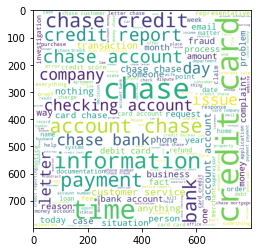

In [17]:
# viewing the wordcloud of all the complaints
wordcloud = WordCloud(width=800,height = 800,background_color ='white',min_font_size=10,stopwords=stopwords).generate(all_sentences)
plt.imshow(wordcloud)

## Topic Modelling

NMF is a matrix factorization technique that can be used for dimensionality reduction and feature extraction in text data. The goal of NMF is to factorize a matrix of non-negative values into two matrices, one with non-negative coefficients and another with non-negative basis vectors, such that their product approximates the original matrix. The basis vectors can be interpreted as topics, and the coefficients as weights that indicate the relevance of each topic to a document. NMF is a popular technique for topic modeling because it produces interpretable and sparse representations of text data.

In [18]:
# converting words to number using tfidf vectorizer
vect = TfidfVectorizer(stop_words='english')
X= vect.fit_transform(complaint_pre_processed)

In [19]:
# topic modelling using NMF
from sklearn.decomposition import NMF
nmf = NMF(n_components=5)
W = nmf.fit_transform(X)
H = nmf.components_

In [20]:
# Printing the Top 10 words per topic

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((5, 10)), index=[f'Topic {i + 1}' for i in range(5)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(5):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,bank,money,check,chase,checking,branch,deposit,number,business
Topic 2,card,chase,credit,charge,dispute,fraud,merchant,company,fee,purchase
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time
Topic 4,credit,report,inquiry,score,debt,account,reporting,information,bureaus,identity
Topic 5,payment,balance,month,fee,statement,date,auto,time,chase,day


In [21]:
# creating a dictionary to map the labels to corresponding categories.
topics ={
    0 : 'bank account services',
    1 :'credit_card',
    2:'mortgage/loans',
    3:'theft/dispute reporting',
    4:'others'
}

In [24]:
# getting the topic assigned the maximum weight
df['max_topic']=W.argmax(axis=1)

In [23]:
# mapping the max topic to the categories using topic dictionary
df['topic_category']= df['max_topic'].map(topics)

In [25]:
# let's print few complaints in each topic
df[['complaint_what_happened','complaint_clean','topic_category']][0:5]

,complaint_what_happened,complaint_clean,topic_category
1,Good morning my name is XXXX XXXX and I apprec...,morning name stop debt verification statement ...,bank account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card agent anniversary date agent information ...,credit_card
10,Chase Card was reported on XX/XX/2019. However...,chase card application identity consent credit...,credit_card
11,"On XX/XX/2018, while trying to book a XXXX XX...",ticket offer ticket card information offer min...,theft/dispute reporting
14,my grand son give me check for {$1600.00} i de...,son check chase account fund chase bank accoun...,bank account services


In [32]:
# distribution of the topics
df['topic_category'].value_counts(normalize=True)

credit_card                0.290243
bank account services      0.284596
mortgage/loans             0.182185
theft/dispute reporting    0.136010
others                     0.106967
Name: topic_category, dtype: float64

## Training the model - Classification task



In [28]:
from sklearn.model_selection import train_test_split
X_transformed = X.toarray()
y = df['max_topic']
X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,test_size=0.2)

In [30]:
print(f"training data size:{X_train.shape}")
print(f"training data size:{X_test.shape}")

training data size:(16857, 13117)
training data size:(4215, 13117)


### Logistic Regression using Hyper-parameter tuning

In [35]:
# training a classification model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,KFold

In [36]:
lr = LogisticRegression()
# defining hyper-parameters to be fine-tuned
param_grid ={
    'C':[0.1,1,10],
    'penalty':['l1','l2']
}

cv = KFold(n_splits=5,shuffle=True, random_state=42)
gridsearch = GridSearchCV(lr,param_grid,cv=cv,n_jobs=-1)
gridsearch.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver l

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [44]:
model=gridsearch.best_estimator_

In [45]:
y_test_predicted=model.predict(X_test)

In [53]:
# printing the performance summary of logistic regression
from sklearn.metrics import classification_report,accuracy_score
print("Classification report on test data\n")
print(classification_report(y_test,y_test_predicted))
accuracy=accuracy_score(y_test,y_test_predicted)
print(f"Accuracy on test data: {accuracy}")

Classification report on test data

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1165
           1       0.96      0.97      0.97      1237
           2       0.97      0.96      0.96       768
           3       0.97      0.93      0.95       586
           4       0.97      0.94      0.95       459

    accuracy                           0.96      4215
   macro avg       0.96      0.96      0.96      4215
weighted avg       0.96      0.96      0.96      4215

Accuracy on test data: 0.963226571767497


### XGBoost classifier

In [55]:
import xgboost as xgb

In [59]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [65]:
X_transformed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
xgb = xgb.XGBClassifier(random_state=42,n_jobs=-1,objective='multi:softmax')
xgb.fit(X_train,y_train)

XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=42)

In [69]:
# printing the performance summary of xgboost 

y_test_pred=xgb.predict(X_test)
print("classification report \n")
print(classification_report(y_test,y_test_pred))
accuracy = accuracy_score(y_test,y_test_pred)
print(f"test accuracy: {accuracy}")

classification report 

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1165
           1       0.92      0.95      0.93      1237
           2       0.91      0.91      0.91       768
           3       0.93      0.88      0.90       586
           4       0.93      0.88      0.90       459

    accuracy                           0.92      4215
   macro avg       0.92      0.91      0.92      4215
weighted avg       0.92      0.92      0.92      4215

test accuracy: 0.9238434163701068


## Dumping the model

From the results it is seen that logistic regression with hyper-paramter tuning performs better than xgboost. We can experiment further by hyperparamter tuning xgboost algorithm. For now we will use logistic regression model for prediction

In [74]:
# dump final model and tf_idf vector
import pickle
with open('model.pkl','wb') as f:
  pickle.dump(model,f)
with open('tf_idf.pkl','wb') as f:
  pickle.dump(vect,f)